# **Laboratorul 12 PMP**

In [1]:
!pip -q install pymc arviz numpy pandas matplotlib seaborn

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()

Saving date_promovare_examen.csv to date_promovare_examen.csv


In [8]:
df = pd.read_csv("date_promovare_examen.csv")
df.head()

y = df["Promovare"].astype(int).values

x1 = df["Ore_Studiu"].astype(float).values
x2 = df["Ore_Somn"].astype(float).values

x1_std = (x1 - x1.mean()) / x1.std()
x2_std = (x2 - x2.mean()) / x2.std()

X = np.column_stack([x1_std, x2_std])


## **a)**

In [12]:
unique, counts = np.unique(y, return_counts=True)
balance = dict(zip(unique, counts))
balance

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    beta  = pm.Normal("beta",  mu=0, sigma=1, shape=2)

    mu = alpha + pm.math.dot(X, beta)
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    yl = pm.Bernoulli("yl", p=theta, observed=y)

    idata = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.99,
        random_seed=42
    )

az.summary(idata, var_names=["alpha","beta"])

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.134,0.471,-0.788,1.002,0.010,0.009,2338.0,1880.0,1.0
beta[0],2.709,0.659,1.535,3.969,0.014,0.012,2169.0,2158.0,1.0
beta[1],3.612,0.620,2.483,4.794,0.013,0.010,2278.0,2418.0,1.0


## **b)**

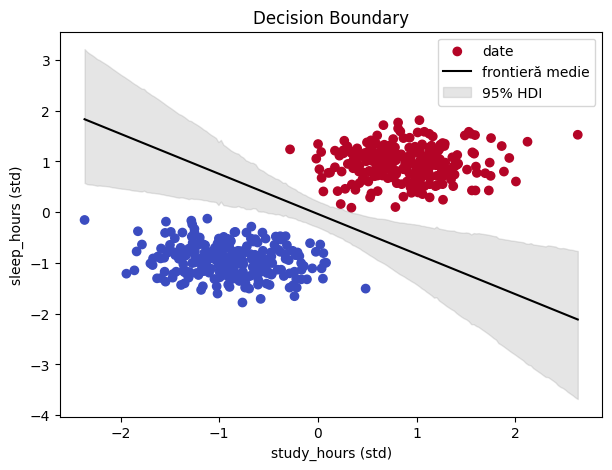

In [17]:
post = idata.posterior

alpha_samples = post["alpha"].values.reshape(-1)

beta_samples = post["beta"].values.reshape(-1, 2)

x1_grid = np.linspace(x1_std.min(), x1_std.max(), 200)

alpha_ = alpha_samples[:, None]
beta1_ = beta_samples[:, 0][:, None]
beta2_ = beta_samples[:, 1][:, None]

x2_grid_post = -(alpha_ + beta1_ * x1_grid) / beta2_

x2_mean = x2_grid_post.mean(axis=0)

x2_lower = np.zeros_like(x1_grid)
x2_upper = np.zeros_like(x1_grid)
for j in range(len(x1_grid)):
    h = az.hdi(x2_grid_post[:, j], hdi_prob=0.95)
    x2_lower[j] = h[0]
    x2_upper[j] = h[1]

plt.figure(figsize=(7,5))
plt.scatter(x1_std, x2_std, c=y, cmap="coolwarm", label="date")
plt.plot(x1_grid, x2_mean, color="black", label="frontieră medie")
plt.fill_between(x1_grid, x2_lower, x2_upper, alpha=0.2, color="gray", label="95% HDI")
plt.xlabel("study_hours (std)")
plt.ylabel("sleep_hours (std)")
plt.title("Decision Boundary")
plt.legend()
plt.show()


## **c)**

In [18]:
post = idata.posterior

beta_samples = post["beta"].stack(sample=("chain","draw")).values

beta1_mean = beta_samples[0].mean()
beta2_mean = beta_samples[1].mean()

beta1_hdi = az.hdi(beta_samples[0], hdi_prob=0.95)
beta2_hdi = az.hdi(beta_samples[1], hdi_prob=0.95)

print("β1 (study_hours):")
print("mean =", beta1_mean)
print("95% HDI =", beta1_hdi)

print("\nβ2 (sleep_hours):")
print("mean =", beta2_mean)
print("95% HDI =", beta2_hdi)

if abs(beta1_mean) > abs(beta2_mean):
    print("=> Orele de studiu influențează mai mult probabilitatea de promovare.")
else:
    print("=> Orele de somn influențează mai mult probabilitatea de promovare.")


β1 (study_hours):
mean = 2.7094891552099907
95% HDI = [1.4589402  3.99488419]

β2 (sleep_hours):
mean = 3.6116826157912163
95% HDI = [2.4792964  4.87495378]
=> Orele de somn influențează mai mult probabilitatea de promovare.
